In [1]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk, plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)

cuda


In [4]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4


[rank: 0] Seed set to 7


In [16]:
class BasicCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-2,
        n_sampling_steps: int = 250, 
        fourier_upweight_range=(3, 10), 
        fourier_weight=1e-5,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        self.fourier_upweight_range = fourier_upweight_range
        self.fourier_weight = fourier_weight
        
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, cdm_map, params) -> Tensor:
        cdm_map = cdm_map
        params = params
        return self.model(cdm_map,params)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        true_map = true_map.to(device)
        mtot_pred = self(cdm_map,params).to(device)
        loss = l1_loss(mtot_pred, true_map)
        self.log("l1_loss", loss, on_epoch=True, prog_bar=True)
        
        if self.current_epoch >= 2:
            fourier_loss = self.fourier_loss(mtot_pred, true_map)
            loss += fourier_loss
            
            # Log the individual loss components
            self.log("fourier_loss", fourier_loss, on_epoch=True, prog_bar=True)
        return loss
    
    def fourier_loss(self, output, target):

        output_fft = torch.fft.fft2(output)
        target_fft = torch.fft.fft2(target)
    
        _, _, H, W = output.shape
        L = 25. #Mpc/c

        kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L)).to(output.device)
        ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L)).to(output.device)
        kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
        k = torch.sqrt(kx**2 + ky**2) 
        
        high = self.fourier_upweight_range[1]
        low = self.fourier_upweight_range[0]
        order = 2 
        low_pass = 1 / (1 + (k / high)**(2 * order))
        high_pass = 1 / (1 + (low / k)**(2 * order))
        weight_mask = self.fourier_weight*low_pass*high_pass #change to Butterworth filter
        
        #weight_mask = torch.zeros_like(k)
        #weight_mask[(k >= low) & (k <= high)] = self.fourier_weight # Double weight in the range
    
        # Expand the mask for all batches and channels
        weight_mask = weight_mask[None, None, :, :].to(output.device)
        loss = torch.mean(weight_mask * (output_fft - target_fft).real ** 2) + torch.mean(weight_mask * (output_fft - target_fft).imag ** 2) #r_cc is phase not mag

        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        loss = self.evaluate(batch, "train")
        self.log("train_loss", loss, on_epoch=True)
        return loss


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params,x = batch 
        loss = self.evaluate(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10, # ~ num_steps // 3
            eta_min=3e-5,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        cdm_map,params,true_map = batch
        return self(cdm_map,params)

In [27]:
import importlib
import unet_parts
import unet_model
import camel_dataloader
import utils

importlib.reload(camel_dataloader) 
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D

importlib.reload(utils) 
importlib.reload(unet_parts) 
from utils import draw_figure

importlib.reload(unet_model) 
from unet_model import UNetFiLM

In [30]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNetFiLM
cnn = BasicCNN(
        model =UNetFiLM(1,1,use_fourier_features=False), #.to(device) #SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    ).to(device)

    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, # 50 6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="baryonize_DM",
            experiment_name='Unet_Film_L1_epoch2_Fourier_weight_1e-5_3_10_Butterworth_lr_1e-3_adamw_1e-2_25_thickness',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #10 1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
print(cnn.device)

cuda:0


In [ ]:
import importlib
import unet_model
import utils
importlib.reload(unet_model) 
importlib.reload(utils) 
from utils import power
from unet_model import UNetFiLM, FiLM

## Conditional CNN + Fourier Loss + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [6]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size)

In [15]:
print(len(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data))

2400 420 180


In [7]:
trainer.fit(model=cnn, datamodule=dm_TF) 

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/f22390c4a6594fc6812d7d1345119c55

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | UNetFiLM | 44.2 M | train
-------------------------------------------
44.2 M    Trainable param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_Film_L1_epoch10_Fourier_weight_1e-5_1_10_Butterworth_high_pass_lr_1e-3_adamw_1e-2_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/f22390c4a6594fc6812d7d1345119c55
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_Film_L1_epoch10_Fourier_weight_1e-5_1_10_Butterworth_high_pass_lr_1e-3_adamw_1e-2_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset                : Astrid
COMET INFO:     fourier_upweight_range : (1, 10)
COMET INFO:     fourier_weight         : 1e-05
COMET IN

NameError: name 'exit' is not defined

In [26]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/5dac20b8da8145bfbbf0feee77f69ffb/checkpoints/latest-epoch=9-step=2000.ckpt


## CNN + TF: m_cdm -> m_tot-m_cdm_tf (3D->2D: 25 thickness)

In [6]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    ) 

In [8]:
print(np.shape(dm_TF.train_data), len(dm_TF.valid_data),len(dm_TF.test_data))
one_batch = next(iter(dm_TF.test_dataloader()))
print(np.shape(one_batch))

(2400, 2, 1, 256, 256) 420 180
(2, 50, 1, 256, 256)


In [ ]:
print(torch.is_floating_point(one_batch[0]), one_batch[0].dtype, one_batch[1].dtype, UNet(1,1)(one_batch[0]).dtype, cnn(one_batch[0]).shape)
for param in cnn.parameters():
    if param.dtype != torch.float32:
        print(f'wrong dtype{param.data.dtype}')

In [7]:
trainer.fit(model=cnn, datamodule=dm_TF) 

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-

Epoch 0: 100%|██████████| 200/200 [00:30<00:00,  6.66it/s, v_num=0cc1]     
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 0: 100%|██████████| 200/200 [00:35<00:00,  5.60it/s, v_num=0cc1]  

Epoch 0, global step 200: 'val_loss' reached 0.19081 (best 0.19081), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=0-step=200.ckpt' as top 1


Epoch 1: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 1: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s, v_num=0cc1]  

Epoch 1, global step 400: 'val_loss' reached 0.19031 (best 0.19031), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=1-step=400.ckpt' as top 1


Epoch 2: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 2: 100%|██████████| 200/200 [00:36<00:00,  5.52it/s, v_num=0cc1]  

Epoch 2, global step 600: 'val_loss' reached 0.19017 (best 0.19017), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=2-step=600.ckpt' as top 1


Epoch 3: 100%|██████████| 200/200 [00:29<00:00,  6.78it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 3: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s, v_num=0cc1]  

Epoch 3, global step 800: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 200/200 [00:29<00:00,  6.76it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 4: 100%|██████████| 200/200 [00:35<00:00,  5.71it/s, v_num=0cc1]  

Epoch 4, global step 1000: 'val_loss' reached 0.18705 (best 0.18705), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=4-step=1000.ckpt' as top 1


Epoch 5: 100%|██████████| 200/200 [00:29<00:00,  6.73it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 5: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s, v_num=0cc1]  

Epoch 5, global step 1200: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 6: 100%|██████████| 200/200 [00:35<00:00,  5.59it/s, v_num=0cc1]  

Epoch 6, global step 1400: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 200/200 [00:29<00:00,  6.69it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 7: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]  

Epoch 7, global step 1600: 'val_loss' reached 0.18493 (best 0.18493), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/best_model-epoch=7-step=1600.ckpt' as top 1


Epoch 8: 100%|██████████| 200/200 [00:29<00:00,  6.72it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 8: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s, v_num=0cc1]  

Epoch 8, global step 1800: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 200/200 [00:29<00:00,  6.69it/s, v_num=0cc1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/35 [00:00<?, ?it/s]cuda:0

Epoch 9: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]  

Epoch 9, global step 2000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, v_num=0cc1]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [10] : (2.4471741852423235e-05, 0.001)
COMET INFO:     val_loss [10] : (0.1849323958158493, 0.19246017932891846)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv

In [8]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

Testing DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]cuda:0


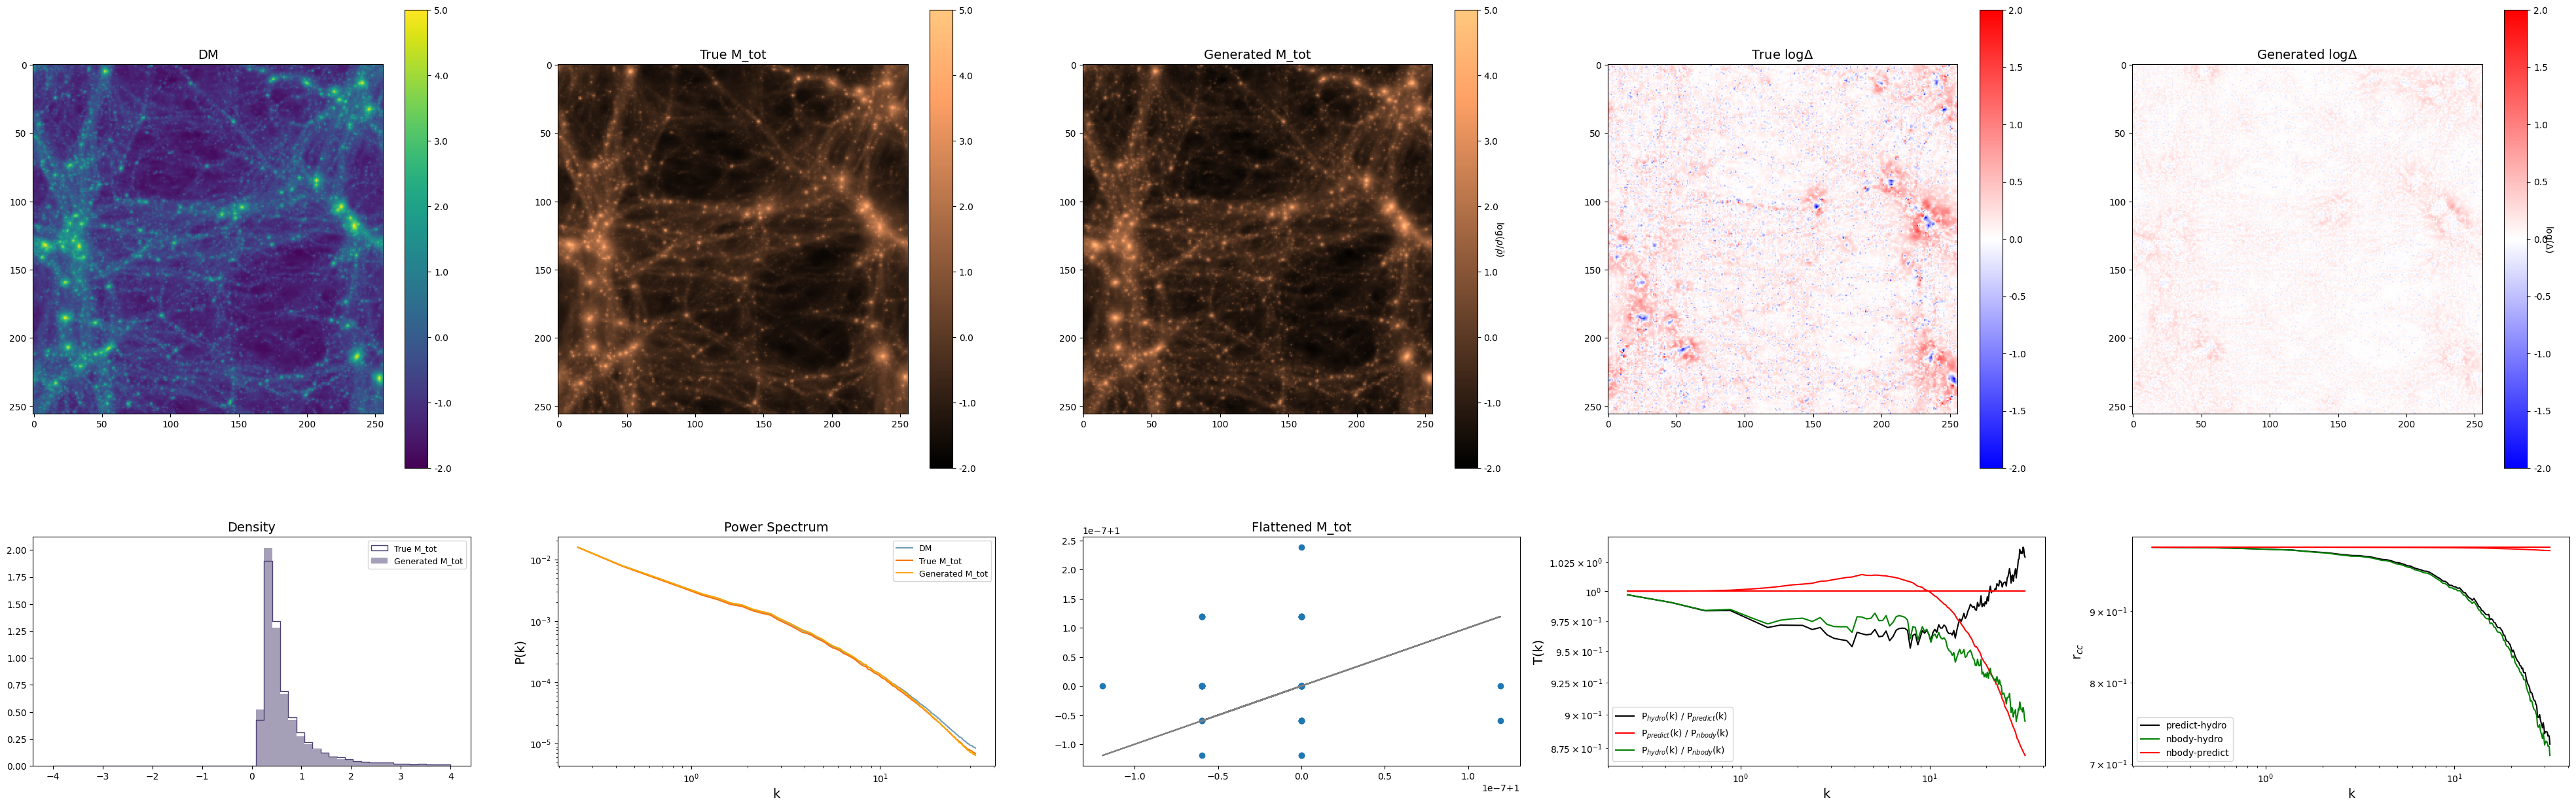

Testing DataLoader 0: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.8404651880264282     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss [2] : (0.2050062119960785, 1.8404651880264282)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64,

In [9]:
path = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt'
test_loss = trainer.test(model=cnn.to(device), datamodule=dm_TF,  ckpt_path = path)

In [10]:
trainer.validate(model=cnn, datamodule=dm_TF, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/7f09ef7fd64d4eac8c2fdf6d960a0cc1/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

Validation DataLoader 0: 100%|██████████| 35/35 [00:05<00:00,  6.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.18671970069408417    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Metrics:
COMET INFO:     val_loss : 0.18671970069408417
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_high_pass
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     model            : UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

[{'val_loss': 0.18671970069408417}]

In [12]:
trainer.logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_TF_L1_high_pass
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/7f09ef7fd64d4eac8c2fdf6d960a0cc1
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_TF_L1_

## Conditional CNN + Fourier Loss: m_cdm -> m_tot-m_cdm (CMD 2D: 5 thickness)

In [8]:
dm = get_astro_data(
        dataset,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )

KeyboardInterrupt: 

In [8]:
one_batch = next(iter(dm.test_dataloader()))

In [9]:
conditioning, params, target = one_batch
print(conditioning.shape, params.shape,target.shape)
print(conditioning.device, params.device,target.device)

torch.Size([50, 1, 256, 256]) torch.Size([50, 6]) torch.Size([50, 1, 256, 256])
cpu cpu cpu


In [15]:
out =UNetFiLM(1,1,use_fourier_features=False)(conditioning,params) #t
print(out.device,out.shape)

cpu torch.Size([50, 1, 256, 256])


In [16]:
path = trainer.checkpoint_callback.best_model_path 
print(path)
path_uncond = '/pscratch/sd/l/lindajin/baryonification_cnn/baryonize_DM/7324872b734c47469bd8054d8263538d/checkpoints/latest-epoch=9-step=10000.ckpt'
path_cond = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/44ed9965667345bda39aaaad1cd9d543/checkpoints/latest-epoch=9-step=8750.ckpt'
path_cond_fourier_loss = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/d42da10304f345e4bc80ec335de35659/checkpoints/latest-epoch=9-step=8750.ckpt' #[3,20], 1e-4
path_cond_fourier_loss = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/106e0975f82c4de1b3f2f7e1f80527ad/checkpoints/latest-epoch=9-step=8750.ckpt' #[3,20], 1e-2
path_UNet_Film_50_epochs_fourier_loss_2_10 = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/9a96658e7271445ebc42cbe7cf86fa99/checkpoints/latest-epoch=49-step=43700.ckpt'
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/46eaa7e31b2f4e1fb4edf0b69e662b5c/checkpoints/latest-epoch=9-step=8750.ckpt'
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_1e7_zero_outside_3_10_lr_5e3 = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/3bc8596614804bb1ae7ff63fd08a6187/checkpoints/latest-epoch=9-step=8850.ckpt'
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_1e7 = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/16c5c8dd1e50401e995e26803a8ccf3d/checkpoints/latest-epoch=9-step=8750.ckpt'

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/3bc8596614804bb1ae7ff63fd08a6187/checkpoints/latest-epoch=9-step=8850.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/3bc8596614804bb1ae7ff63fd08a6187/checkpoints/latest-epoch=9-step=8850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Testing DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing powe

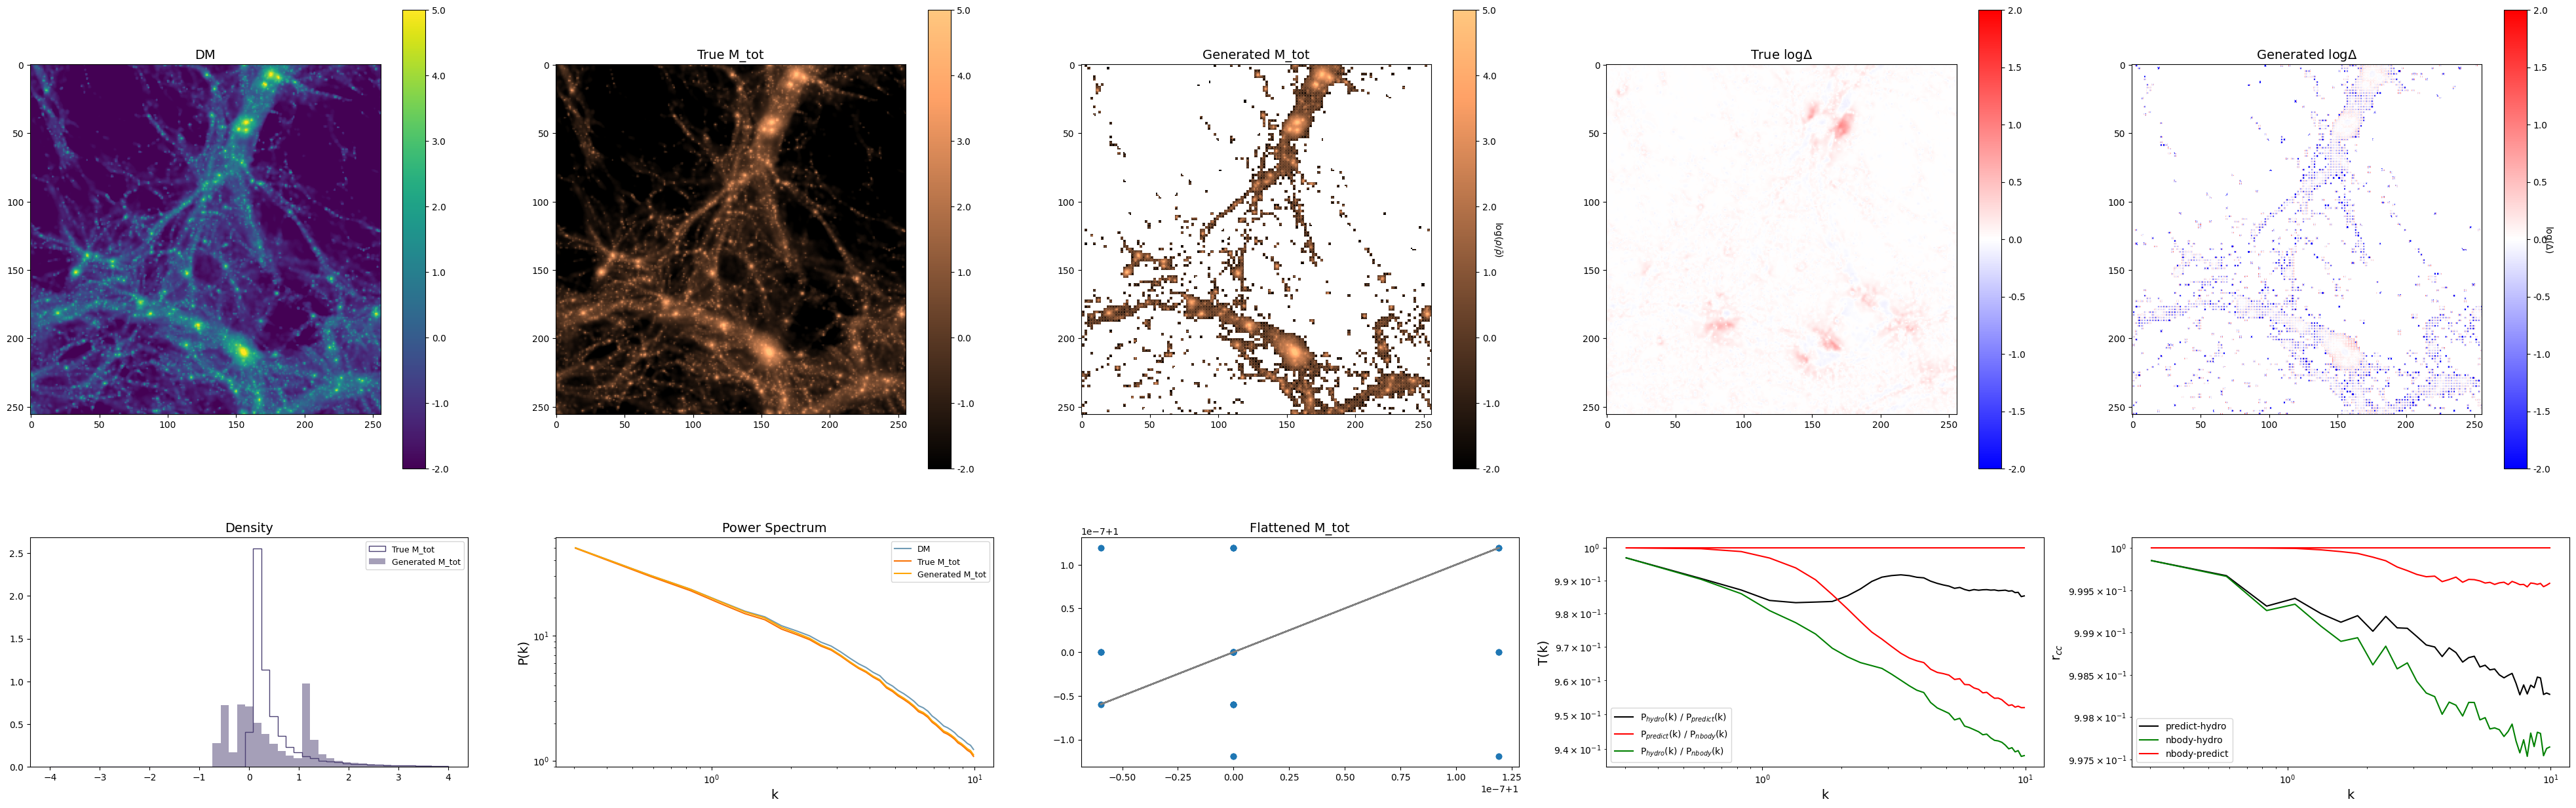

Testing DataLoader 0: 100%|██████████| 30/30 [01:06<00:00,  0.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.2105329036712646     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_ONLY_high_pass_1e-7_zero_outside_3_10_lr_5e-3
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_loss [2] : (0.000146178383147344, 1.2105329036712646)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_ONLY_high_pass_1e-7_zero_outside_3_10_lr_5e-3
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model

In [17]:
test_loss = trainer.test(model=cnn, datamodule=dm,  ckpt_path = path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_1e7_zero_outside_3_10_lr_5e3)

In [18]:
trainer.validate(model=cnn, datamodule=dm, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/3bc8596614804bb1ae7ff63fd08a6187/checkpoints/latest-epoch=9-step=8850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0710924863815308     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_ONLY_high_pass_1e-7_zero_outside_3_10_lr_5e-3
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187
COMET INFO:   Metrics:
COMET INFO:     val_loss : 1.0710924863815308
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_ONLY_high_pass_1e-7_zero_outside_3_10_lr_5e-3
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
   

[{'val_loss': 1.0710924863815308}]

In [19]:
trainer.logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_ONLY_high_pass_1e-7_zero_outside_3_10_lr_5e-3
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/3bc8596614804bb1ae7ff63fd08a6187
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-light

## Conditional CNN + Fourier Loss: m_cdm -> m_tot-m_cdm (3D->2D: 25 thickness)

In [9]:
dm_25_thick = get_astro_data(
        dataset,
        num_workers=num_workers,
        # resize=cropsize,
        batch_size=batch_size,
    )

In [29]:
conditioning, params, target = next(iter(dm_25_thick.test_dataloader()))
cnn.to('cpu')(conditioning, params)

no high pass


tensor([[[[ 7.0753e-03,  1.6312e-02, -1.6477e-02,  ...,  1.0487e-02,
           -2.7790e-02,  1.0614e-02],
          [-1.4036e-02, -1.6030e-02,  1.1071e-02,  ..., -2.4079e-02,
            2.5934e-02, -2.5312e-02],
          [-3.1652e-02, -9.6196e-03,  1.4831e-02,  ...,  8.8594e-03,
            5.9139e-03,  8.4295e-03],
          ...,
          [-1.5188e-02, -1.9581e-02, -3.2782e-03,  ...,  4.6186e-04,
           -8.3002e-03, -1.0741e-02],
          [-1.2120e-02,  1.7715e-02,  1.5350e-02,  ..., -4.1635e-03,
           -7.2988e-03,  1.2908e-02],
          [ 2.5226e-02, -4.0883e-02,  2.1074e-02,  ..., -2.8170e-02,
            2.0009e-02, -3.6978e-02]]],


        [[[ 3.7466e-03,  2.0206e-05,  4.1655e-03,  ..., -1.4888e-04,
            5.4315e-03, -8.0530e-04],
          [ 2.0833e-02, -1.5288e-02,  2.1440e-02,  ..., -1.5082e-02,
            1.9740e-02, -1.7025e-02],
          [ 5.7455e-03,  1.1487e-03,  8.2684e-03,  ..., -6.7639e-04,
            6.1032e-03, -8.8639e-04],
          ...,
   

In [27]:
print(len(dm_25_thick.train_data), len(dm_25_thick.valid_data),len(dm_25_thick.test_data))

2100 600 300


In [31]:
trainer.fit(model=cnn, datamodule=dm_25_thick) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/063589d4efa3418d9728cd32a7ab2ee3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | UNetFiLM | 44.2 M | train
-------------------------------------------
44.2 M    Trainable params
0         Non-trainable params
44.2 M    Total params
176.874   Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_s

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time tak

Epoch 0, global step 175: 'val_loss' reached 0.05030 (best 0.05030), saving model to '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/063589d4efa3418d9728cd32a7ab2ee3/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


Epoch 1: 100%|██████████| 175/175 [00:27<00:00,  6.36it/s, v_num=2ee3, l1_loss_step=0.0417, l1_loss=0.0503, val_loss=0.0503, l1_loss_epoch=0.0552]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 secon

Epoch 1, global step 350: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 175/175 [00:27<00:00,  6.42it/s, v_num=2ee3, l1_loss_step=0.0528, l1_loss=0.0566, val_loss=0.0566, l1_loss_epoch=0.0497, fourier_loss_step=0.0182]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.

Epoch 2, global step 525: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 175/175 [00:28<00:00,  6.19it/s, v_num=2ee3, l1_loss_step=0.0488, l1_loss=0.0486, val_loss=0.0641, l1_loss_epoch=0.0507, fourier_loss_step=0.0151, fourier_loss=0.0155, fourier_loss_epoch=0.0169]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra 

Epoch 3, global step 700: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 175/175 [00:28<00:00,  6.20it/s, v_num=2ee3, l1_loss_step=0.0462, l1_loss=0.0482, val_loss=0.0637, l1_loss_epoch=0.0491, fourier_loss_step=0.00943, fourier_loss=0.0156, fourier_loss_epoch=0.0152]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra

Epoch 4, global step 875: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 175/175 [00:28<00:00,  6.17it/s, v_num=2ee3, l1_loss_step=0.0444, l1_loss=0.0541, val_loss=0.0678, l1_loss_epoch=0.0481, fourier_loss_step=0.0101, fourier_loss=0.0137, fourier_loss_epoch=0.0137]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra 

Epoch 5, global step 1050: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 175/175 [00:28<00:00,  6.19it/s, v_num=2ee3, l1_loss_step=0.0466, l1_loss=0.0508, val_loss=0.0664, l1_loss_epoch=0.047, fourier_loss_step=0.0185, fourier_loss=0.0156, fourier_loss_epoch=0.0127]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra o

Epoch 6, global step 1225: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 175/175 [00:28<00:00,  6.24it/s, v_num=2ee3, l1_loss_step=0.0393, l1_loss=0.0443, val_loss=0.0543, l1_loss_epoch=0.046, fourier_loss_step=0.00716, fourier_loss=0.010, fourier_loss_epoch=0.0117]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra o

Epoch 7, global step 1400: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 175/175 [00:28<00:00,  6.19it/s, v_num=2ee3, l1_loss_step=0.0509, l1_loss=0.0474, val_loss=0.0635, l1_loss_epoch=0.0448, fourier_loss_step=0.0129, fourier_loss=0.0161, fourier_loss_epoch=0.0105]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra 

Epoch 8, global step 1575: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 175/175 [00:27<00:00,  6.26it/s, v_num=2ee3, l1_loss_step=0.0349, l1_loss=0.0425, val_loss=0.0506, l1_loss_epoch=0.0441, fourier_loss_step=0.00503, fourier_loss=0.00807, fourier_loss_epoch=0.00982]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]no high pass
no high pass
cuda:0

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.01 seconds

Computing power spect

Epoch 9, global step 1750: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:37<00:00,  4.63it/s, v_num=2ee3, l1_loss_step=0.0349, l1_loss=0.0442, val_loss=0.0545, l1_loss_epoch=0.0433, fourier_loss_step=0.00503, fourier_loss=0.0104, fourier_loss_epoch=0.00923]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_Film_L1_epoch2_Fourier_weight_1e-5_3_10_Butterworth_lr_1e-3_adamw_1e-2_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/063589d4efa3418d9728cd32a7ab2ee3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [8]       : (0.008072799071669579, 0.016051698476076126)
COMET INFO:     fourier_loss_epoch [8] : (0.009225170128047466, 0.016901222988963127)
COMET INFO:     fourier_loss_step [28] : (0.005025945138186216, 0.03528561443090439)
COMET INFO:     l1_loss [10]           : (0.04250551387667656, 0.05655038729310036)
COMET INFO:     l1_loss_epoch [10]     : (0.04330422356724739, 0.05522

In [32]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/baryonize_DM/063589d4efa3418d9728cd32a7ab2ee3/checkpoints/latest-epoch=9-step=1750.ckpt


In [8]:
path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt'
path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick = '/pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt'

## test if CNN_apply is correct --> ✅

In [70]:
test_predictions_ONLY_fourier_loss = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_fourier_loss_3_10_zeros_elsewhere_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/5ef90d60aaca4012837cd4275273e171/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.50it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

In [72]:
test_predictions_ONLY_fourier_loss = np.array(test_predictions_ONLY_fourier_loss).reshape([2100,256,256]) #path_UNet_Film_50_epochs_fourier_loss_2_10

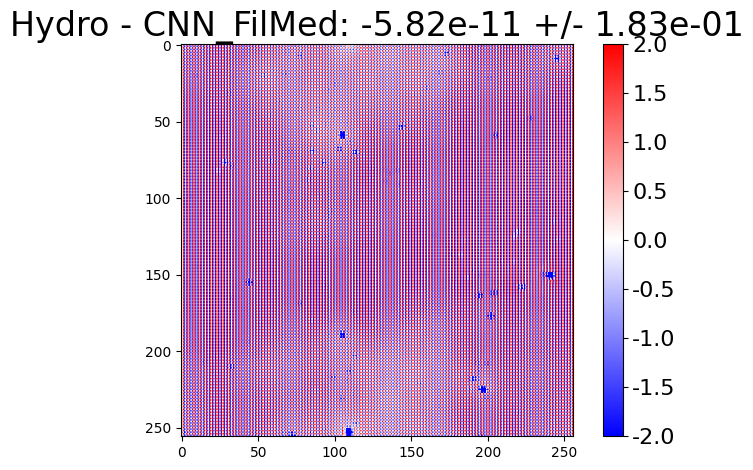

In [73]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
plt.figure()
#diff = np.log(np.mean(hydro_grid + 1, 2)) - np.log(postTF_grid + 1)    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

vmin = -2.0
vmax = 2.0
'''
im = plt.imshow(test_predictions[0], cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hydro - CNN_FilMed: {test_predictions[0].mean():.2e} +/- {test_predictions[0].std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()
'''
im = plt.imshow(test_predictions_ONLY_fourier_loss[50], cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title(f'Hydro - CNN_FilMed: {test_predictions[50].mean():.2e} +/- {test_predictions[50].std():.2e}', fontsize=24)
plt.tight_layout()
plt.show()

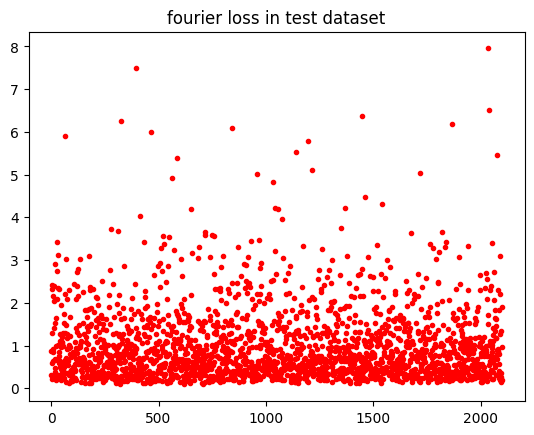

In [86]:
test_target = []
for t in dm_25_thick.train_data:
    test_target.append(t[2])
    
test_predictions_ONLY_fourier_loss_ = Tensor(np.array(test_predictions_ONLY_fourier_loss)).unsqueeze(1)
test_predictions_ = Tensor(test_predictions).unsqueeze(1)

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.show()

In [84]:
print(len(test_target))

2100


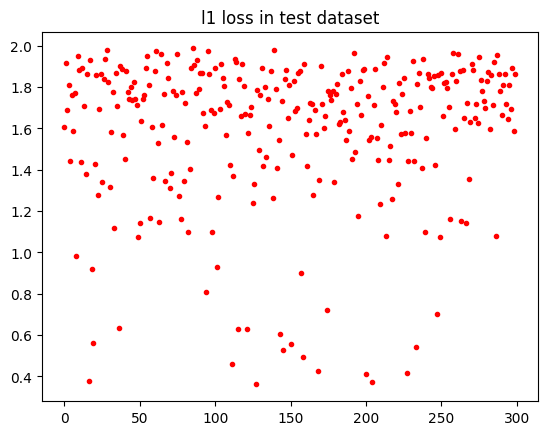

In [44]:
plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions_[i].unsqueeze(0), test_targets_[i])
    plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.show()

In [75]:
test_predictions = trainer.predict(model=cnn, dataloaders=dm_25_thick.train_dataloader(), ckpt_path = path_UNet_Film_10_epochs_ONLY_l1_loss_25_thick)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/baryonize_DM/62ce892d8ce84414ad1d864f0b3c09a3/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

Predicting DataLoader 0: 100%|██████████| 175/175 [00:05<00:00, 29.36it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/96071eeeabd64a0da32d6e71b78e41a9
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Unet_new_Film_Fourier_L1_weight_1e-4_2_20_high_pass_lr_5e-3_25_thickness
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.005
COMET INFO:     model            : UNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel

train on L1 only


/tmp/ipykernel_1997182/3169583532.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))


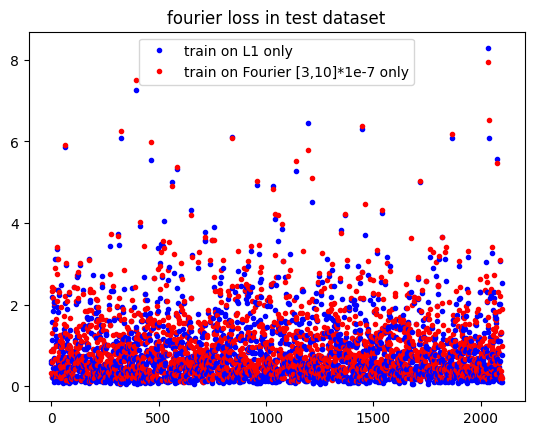

/tmp/ipykernel_1997182/3169583532.py:23: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
/tmp/ipykernel_1997182/3169583532.py:28: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])


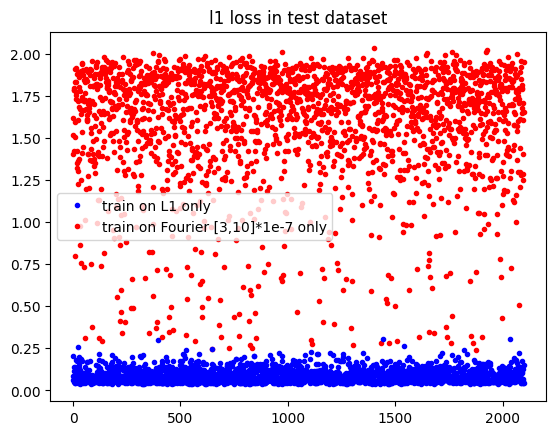

In [87]:
print('train on L1 only')

test_predictions = Tensor(np.array(test_predictions).reshape([2100,1,256,256]))

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss = cnn.fourier_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = cnn.fourier_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('fourier loss in test dataset')
plt.legend()
plt.show()

plt.figure()
for i in np.arange(len(test_predictions)):                
    loss =  l1_loss(test_predictions[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='b', label = 'train on L1 only')
    else:
        plt.plot(i, loss, '.', c='b')
    loss = l1_loss(test_predictions_ONLY_fourier_loss_[i].unsqueeze(0), test_target[i])
    if i == 0:
        plt.plot(i, loss, '.', c='r', label = 'train on Fourier [3,10]*1e-7 only')
    else:
        plt.plot(i, loss, '.', c='r')
plt.title('l1 loss in test dataset')
plt.legend()
plt.show()